In [ ]:
# pip install pycaret

In [ ]:
import os
os.chdir('drive/MyDrive/ToyotaKK')

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [ ]:
def extract_datetime(df):

  df['Timestamp'] = pd.to_datetime(df['Timestamp'])

  df['dayofweek'] = df['Timestamp'].dt.dayofweek
  df['week'] = df['Timestamp'].dt.isocalendar().week
  df['month'] = df['Timestamp'].dt.month

  return df

In [ ]:
kwh_perday = pd.read_csv('kwh_perday.csv').dropna()
kwh_perday = extract_datetime(kwh_perday)
kwh_perday.head()

,Timestamp,BP_KWH,EV_KWH,GS_KWH,SURE_KWH,VM_KWH,ACE_KWH,ShowRoom_KWH,dayofweek,week,month
1,2023-07-19,74.7,28.5,511.5,84.1,232.9,1096.0,1554.7,2,29,7
2,2023-07-20,95.1,44.2,489.2,80.8,237.5,830.8,1554.0,3,29,7
3,2023-07-21,112.1,0.5,527.0,87.3,240.5,863.7,1465.6,4,29,7
4,2023-07-22,70.8,47.7,590.9,87.5,290.2,1180.0,1534.0,5,29,7
5,2023-07-23,12.3,32.7,52.6,34.1,50.6,1248.6,886.5,6,29,7


## Create labels (energy used in the day after in all area)

In [ ]:
kwh_perday['ALL_KWH'] = kwh_perday['BP_KWH'] + kwh_perday['EV_KWH'] + kwh_perday['GS_KWH'] + kwh_perday['SURE_KWH'] + kwh_perday['VM_KWH'] + kwh_perday['ACE_KWH'] + kwh_perday['ShowRoom_KWH']


In [ ]:
kwh_perday['tomorrow'] = kwh_perday['ALL_KWH'].shift(-1)
kwh_perday

,Timestamp,BP_KWH,EV_KWH,GS_KWH,SURE_KWH,VM_KWH,ACE_KWH,ShowRoom_KWH,dayofweek,week,month,ALL_KWH,tomorrow
1,2023-07-19,74.7,28.5,511.5,84.1,232.9,1096.0,1554.7,2,29,7,3582.4,3331.6
2,2023-07-20,95.1,44.2,489.2,80.8,237.5,830.8,1554.0,3,29,7,3331.6,3296.7
3,2023-07-21,112.1,0.5,527.0,87.3,240.5,863.7,1465.6,4,29,7,3296.7,3801.1
4,2023-07-22,70.8,47.7,590.9,87.5,290.2,1180.0,1534.0,5,29,7,3801.1,2317.4
5,2023-07-23,12.3,32.7,52.6,34.1,50.6,1248.6,886.5,6,29,7,2317.4,3031.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,2024-01-12,49.7,1.6,357.6,55.5,170.6,-127.3,2365.4,4,2,1,2873.1,2767.0
179,2024-01-13,80.9,47.6,315.9,72.0,151.2,-127.1,2226.5,5,2,1,2767.0,1201.1
180,2024-01-14,42.2,-4.4,45.4,24.0,33.0,-139.5,1200.4,6,2,1,1201.1,2939.9
181,2024-01-15,18.1,31.0,340.2,65.1,180.0,9.5,2296.0,0,3,1,2939.9,252.3


# Split data

In [ ]:
kwh_perday.Timestamp.nunique()
# total of 160 days
# training data 80% = 128 days
# test data 20% = 32 days

160

In [ ]:
kwh_perday[(kwh_perday.month!=1)&(kwh_perday.month<12)].Timestamp.nunique()
# split by month
# training data: July-November 113 days
# test data: December-January 47 days

113

In [ ]:
train = kwh_perday[(kwh_perday.month!=1)&(kwh_perday.month<12)]
test = kwh_perday[(kwh_perday.month==1)|(kwh_perday.month==12)]
print(len(train), len(test))

113 47


<ipython-input-37-1f82f53548a5>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train.corr(method='kendall')


<Axes: >

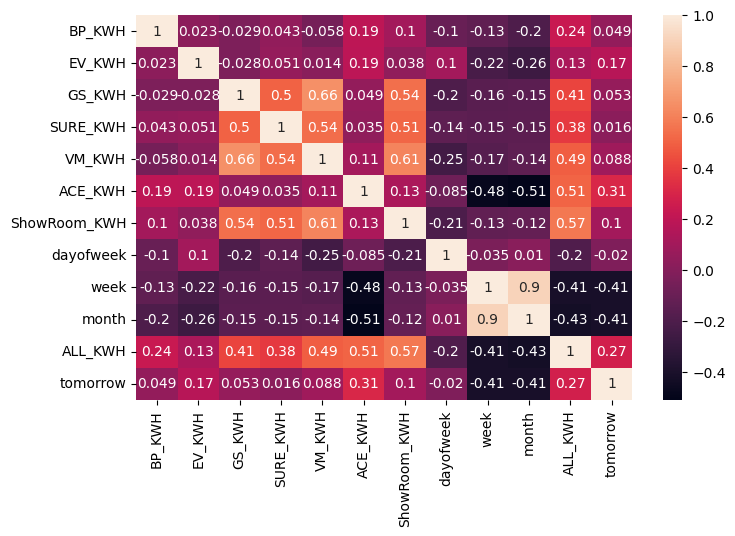

In [ ]:
corr = train.corr(method='kendall')
fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(corr, annot=True)

# Explore models

In [ ]:
# import the regression module
from pycaret.regression import *

In [ ]:
# initialize setup
s = setup(
    data = train,
    #test_data = test,
    target = 'tomorrow',
    fold = 4,
    fold_strategy = 'timeseries',
    fold_shuffle = False,
    data_split_shuffle = False,

    session_id = 123
    )

,Description,Value
0,Session id,123
1,Target,tomorrow
2,Target type,Regression
3,Original data shape,"(113, 13)"
4,Transformed data shape,"(113, 15)"
5,Transformed train set shape,"(79, 15)"
6,Transformed test set shape,"(34, 15)"
7,Numeric features,11
8,Date features,1
9,Preprocess,True


In [ ]:
best = compare_models(sort = 'R2', cross_validation = True,)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,605.4454,632923.5245,736.9781,-1.1284,0.4439,0.4665,0.1625
xgboost,Extreme Gradient Boosting,659.6674,701741.4492,759.3733,-1.4975,0.4492,0.4888,0.0950
rf,Random Forest Regressor,688.0926,748563.8995,794.0289,-1.5444,0.4655,0.5181,0.1975
ada,AdaBoost Regressor,665.1577,795127.2604,792.3713,-1.6713,0.4620,0.5239,0.1100
br,Bayesian Ridge,670.3219,832379.1024,839.0746,-1.9319,0.5100,0.5932,0.0450
lightgbm,Light Gradient Boosting Machine,690.3560,843576.1901,848.5436,-1.9740,0.5129,0.6013,0.1475
gbr,Gradient Boosting Regressor,750.4611,910196.6778,880.5344,-2.1213,0.5003,0.5215,0.0875
knn,K Neighbors Regressor,743.3327,918457.4570,875.6685,-2.2252,0.5055,0.6057,0.0575
omp,Orthogonal Matching Pursuit,827.1886,1101384.9386,974.3930,-2.9662,0.5606,0.7126,0.0425
dummy,Dummy Regressor,893.0175,1130011.1562,1028.3256,-3.2325,0.5872,0.7659,0.0425


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [ ]:
train['BP_KWH_6days'] = train['BP_KWH'].shift(6)
train

,Timestamp,BP_KWH,EV_KWH,GS_KWH,SURE_KWH,VM_KWH,ACE_KWH,ShowRoom_KWH,dayofweek,week,month,ALL_KWH,tomorrow,BP_KWH_6days
1,2023-07-19,74.7,28.5,511.5,84.1,232.9,1096.0,1554.7,2,29,7,3582.4,3331.6,NaN
2,2023-07-20,95.1,44.2,489.2,80.8,237.5,830.8,1554.0,3,29,7,3331.6,3296.7,NaN
3,2023-07-21,112.1,0.5,527.0,87.3,240.5,863.7,1465.6,4,29,7,3296.7,3801.1,NaN
4,2023-07-22,70.8,47.7,590.9,87.5,290.2,1180.0,1534.0,5,29,7,3801.1,2317.4,NaN
5,2023-07-23,12.3,32.7,52.6,34.1,50.6,1248.6,886.5,6,29,7,2317.4,3031.6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,2023-11-26,-74.4,0.6,43.8,30.4,36.3,-425.2,733.3,6,47,11,344.8,1948.6,41.7
132,2023-11-27,160.9,2.2,338.5,65.4,169.8,173.7,1038.1,0,48,11,1948.6,1305.4,51.9
133,2023-11-28,-76.0,1.8,334.5,64.9,138.0,-212.9,1055.1,1,48,11,1305.4,1625.7,37.4
134,2023-11-29,20.2,3.0,371.4,61.5,193.1,-43.5,1020.0,2,48,11,1625.7,1469.5,69.9


In [ ]:
# add feature of 6-day-before kWH
for col_name in ['BP_KWH', 'EV_KWH',	'GS_KWH',	'SURE_KWH',	'VM_KWH',	'ACE_KWH','ShowRoom_KWH']:
  lag_col = col_name + '_6days'
  train[lag_col] = train[col_name].shift(6)
  train[lag_col] = np.where(train[lag_col].isnull(), train[col_name], train[lag_col])

train.head(10)

,Timestamp,BP_KWH,EV_KWH,GS_KWH,SURE_KWH,VM_KWH,ACE_KWH,ShowRoom_KWH,dayofweek,week,month,ALL_KWH,tomorrow,BP_KWH_6days,EV_KWH_6days,GS_KWH_6days,SURE_KWH_6days,VM_KWH_6days,ACE_KWH_6days,ShowRoom_KWH_6days
1,2023-07-19,74.7,28.5,511.5,84.1,232.9,1096.0,1554.7,2,29,7,3582.4,3331.6,74.7,28.5,511.5,84.1,232.9,1096.0,1554.7
2,2023-07-20,95.1,44.2,489.2,80.8,237.5,830.8,1554.0,3,29,7,3331.6,3296.7,95.1,44.2,489.2,80.8,237.5,830.8,1554.0
3,2023-07-21,112.1,0.5,527.0,87.3,240.5,863.7,1465.6,4,29,7,3296.7,3801.1,112.1,0.5,527.0,87.3,240.5,863.7,1465.6
4,2023-07-22,70.8,47.7,590.9,87.5,290.2,1180.0,1534.0,5,29,7,3801.1,2317.4,70.8,47.7,590.9,87.5,290.2,1180.0,1534.0
5,2023-07-23,12.3,32.7,52.6,34.1,50.6,1248.6,886.5,6,29,7,2317.4,3031.6,12.3,32.7,52.6,34.1,50.6,1248.6,886.5
6,2023-07-24,35.9,0.7,469.4,58.9,238.2,1092.4,1136.1,0,30,7,3031.6,3023.1,35.9,0.7,469.4,58.9,238.2,1092.4,1136.1
7,2023-07-25,106.5,28.0,398.2,63.5,185.9,1055.0,1186.0,1,30,7,3023.1,3487.8,74.7,28.5,511.5,84.1,232.9,1096.0,1554.7
8,2023-07-26,65.6,63.2,434.6,72.0,226.7,1281.6,1344.1,2,30,7,3487.8,365.9,95.1,44.2,489.2,80.8,237.5,830.8,1554.0
9,2023-07-27,-9.0,0.5,71.0,14.9,42.3,226.6,19.6,3,30,7,365.9,2802.1,112.1,0.5,527.0,87.3,240.5,863.7,1465.6
21,2023-08-08,56.4,24.8,389.0,84.6,198.4,894.0,1154.9,1,32,8,2802.1,3144.7,70.8,47.7,590.9,87.5,290.2,1180.0,1534.0


In [ ]:
train = train.drop(columns=['week', 'month'])
train.head()

,Timestamp,BP_KWH,EV_KWH,GS_KWH,SURE_KWH,VM_KWH,ACE_KWH,ShowRoom_KWH,dayofweek,ALL_KWH,tomorrow,BP_KWH_6days,EV_KWH_6days,GS_KWH_6days,SURE_KWH_6days,VM_KWH_6days,ACE_KWH_6days,ShowRoom_KWH_6days
1,2023-07-19,74.7,28.5,511.5,84.1,232.9,1096.0,1554.7,2,3582.4,3331.6,74.7,28.5,511.5,84.1,232.9,1096.0,1554.7
2,2023-07-20,95.1,44.2,489.2,80.8,237.5,830.8,1554.0,3,3331.6,3296.7,95.1,44.2,489.2,80.8,237.5,830.8,1554.0
3,2023-07-21,112.1,0.5,527.0,87.3,240.5,863.7,1465.6,4,3296.7,3801.1,112.1,0.5,527.0,87.3,240.5,863.7,1465.6
4,2023-07-22,70.8,47.7,590.9,87.5,290.2,1180.0,1534.0,5,3801.1,2317.4,70.8,47.7,590.9,87.5,290.2,1180.0,1534.0
5,2023-07-23,12.3,32.7,52.6,34.1,50.6,1248.6,886.5,6,2317.4,3031.6,12.3,32.7,52.6,34.1,50.6,1248.6,886.5


In [ ]:
# initialize setup
s = setup(
    data = train,
    #test_data = test,
    target = 'tomorrow',
    fold = 4,
    fold_strategy = 'timeseries',
    fold_shuffle = False,
    data_split_shuffle = False,

    session_id = 123
    )

best = compare_models(sort = 'R2', cross_validation = True,)

,Description,Value
0,Session id,123
1,Target,tomorrow
2,Target type,Regression
3,Original data shape,"(113, 18)"
4,Transformed data shape,"(113, 20)"
5,Transformed train set shape,"(79, 20)"
6,Transformed test set shape,"(34, 20)"
7,Numeric features,16
8,Date features,1
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,609.8885,678907.5859,732.1556,-1.2465,0.4320,0.4696,0.2775
rf,Random Forest Regressor,641.2028,716842.8761,753.4168,-1.3869,0.4404,0.4922,0.3475
gbr,Gradient Boosting Regressor,629.3799,712121.4858,756.5725,-1.3948,0.4346,0.4626,0.1500
xgboost,Extreme Gradient Boosting,657.4216,744481.1328,779.4477,-1.6281,0.4598,0.4912,0.1025
br,Bayesian Ridge,661.8474,779112.6916,790.5622,-1.7053,0.4805,0.5600,0.0475
knn,K Neighbors Regressor,704.7927,839795.7617,816.0399,-1.8687,0.4782,0.5622,0.0875
ada,AdaBoost Regressor,679.9768,845575.1816,810.3834,-1.9543,0.4731,0.5537,0.1875
lightgbm,Light Gradient Boosting Machine,719.7025,902341.5221,887.4650,-2.1976,0.5251,0.6236,0.2500
dt,Decision Tree Regressor,788.8150,1075194.2626,963.3417,-2.4802,0.6379,0.5638,0.0850
par,Passive Aggressive Regressor,797.6990,1138528.5964,969.3035,-2.9459,0.5464,0.6679,0.0450


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [ ]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, hidden_layers=64):
        super(LSTM, self).__init__()
        self.hidden_layers = hidden_layers
        # lstm1, lstm2, linear are all layers in the network
        self.lstm1 = nn.LSTMCell(1, self.hidden_layers)
        self.lstm2 = nn.LSTMCell(self.hidden_layers, self.hidden_layers)
        self.linear = nn.Linear(self.hidden_layers, 1)

    def forward(self, y, future_preds=0):
        outputs, num_samples = [], y.size(0)
        h_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        c_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        h_t2 = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        c_t2 = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)

        for time_step in y.split(1, dim=1):
            # N, 1
            h_t, c_t = self.lstm1(input_t, (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            output = self.linear(h_t2) # output from the last FC layer
            outputs.append(output)

        for i in range(future_preds):
            # this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        # transform list to tensor
        outputs = torch.cat(outputs, dim=1)
        return outputs

In [ ]:
model = LSTM()
criterion = nn.MSELoss()
optimiser = torch.optim.LBFGS(model.parameters(), lr=0.08)

# Univariate

In [ ]:
train = kwh_perday[(kwh_perday.month!=1)&(kwh_perday.month<12)]
bp_train = train[['Timestamp', 'BP_KWH', 'dayofweek']]

In [ ]:
bp_train['lag_6days'] = bp_train['BP_KWH'].shift(6)
bp_train['lag_6days'] = np.where(bp_train['lag_6days'].isnull(), bp_train['BP_KWH'], bp_train['lag_6days'])
bp_train['tomorrow'] = bp_train['BP_KWH'].shift(-1)

bp_train = bp_train.dropna()
bp_train.head()

,Timestamp,BP_KWH,dayofweek,lag_6days,tomorrow
1,2023-07-19,74.7,2,74.7,95.1
2,2023-07-20,95.1,3,95.1,112.1
3,2023-07-21,112.1,4,112.1,70.8
4,2023-07-22,70.8,5,70.8,12.3
5,2023-07-23,12.3,6,12.3,35.9


In [ ]:
# initialize setup
s = setup(
    data = bp_train,
    #test_data = test,
    target = 'tomorrow',
    fold = 4,
    fold_strategy = 'timeseries',
    fold_shuffle = False,
    data_split_shuffle = False,

    session_id = 123
    )

best = compare_models(sort = 'R2', cross_validation = True,)

# from stationary test BP_KWH is stationary >> possible that predicting the mean is best?

,Description,Value
0,Session id,123
1,Target,tomorrow
2,Target type,Regression
3,Original data shape,"(111, 5)"
4,Transformed data shape,"(111, 7)"
5,Transformed train set shape,"(77, 7)"
6,Transformed test set shape,"(34, 7)"
7,Numeric features,3
8,Date features,1
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,40.3133,3697.6579,57.0462,-0.1652,1.0071,3.9233,0.0850
dummy,Dummy Regressor,44.1649,3874.7829,58.9022,-0.2293,1.1113,5.2280,0.0425
br,Bayesian Ridge,43.5589,3956.3137,58.9576,-0.2343,1.1138,4.5642,0.0800
en,Elastic Net,44.2925,3938.9825,59.1668,-0.2767,1.1910,2.6109,0.0800
huber,Huber Regressor,43.1830,3843.8044,58.7480,-0.2773,1.1030,2.0264,0.1175
lightgbm,Light Gradient Boosting Machine,43.6629,3860.0617,59.6013,-0.2967,1.1037,2.5737,0.1950
rf,Random Forest Regressor,45.9443,4455.0699,62.3041,-0.3851,1.0853,3.7327,0.1950
knn,K Neighbors Regressor,45.3153,4407.1803,62.4817,-0.3979,1.1373,5.7571,0.0825
gbr,Gradient Boosting Regressor,50.1518,4646.2344,64.7068,-0.5121,1.2149,4.5029,0.0825
et,Extra Trees Regressor,45.4900,4241.1686,63.5274,-0.5412,1.1514,2.0122,0.1550


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [ ]:
train = kwh_perday[(kwh_perday.month!=1)&(kwh_perday.month<12)]
sure_train = train[['Timestamp', 'SURE_KWH', 'dayofweek']]

sure_train['lag_6days'] = sure_train['SURE_KWH'].shift(6)
sure_train['lag_6days'] = np.where(sure_train['lag_6days'].isnull(), sure_train['SURE_KWH'], sure_train['lag_6days'])
sure_train['tomorrow'] = sure_train['SURE_KWH'].shift(-1)

sure_train = sure_train.dropna()
sure_train.head()

,Timestamp,SURE_KWH,dayofweek,lag_6days,tomorrow
1,2023-07-19,84.1,2,84.1,80.8
2,2023-07-20,80.8,3,80.8,87.3
3,2023-07-21,87.3,4,87.3,87.5
4,2023-07-22,87.5,5,87.5,34.1
5,2023-07-23,34.1,6,34.1,58.9


In [ ]:
# initialize setup
s = setup(
    data = sure_train,
    #test_data = test,
    target = 'tomorrow',
    fold = 4,
    fold_strategy = 'timeseries',
    fold_shuffle = False,
    data_split_shuffle = False,

    session_id = 123
    )

best = compare_models(sort = 'R2', cross_validation = True,)

# from stationary test BP_KWH is non-stationary >> why able to predict?

,Description,Value
0,Session id,123
1,Target,tomorrow
2,Target type,Regression
3,Original data shape,"(112, 5)"
4,Transformed data shape,"(112, 7)"
5,Transformed train set shape,"(78, 7)"
6,Transformed test set shape,"(34, 7)"
7,Numeric features,3
8,Date features,1
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
dt,Decision Tree Regressor,9.5333,136.9787,11.5776,0.6236,0.1937,0.1559,0.0425
et,Extra Trees Regressor,11.4190,199.7434,13.0079,0.4211,0.2060,0.1735,0.1525
xgboost,Extreme Gradient Boosting,10.5981,209.4394,13.2924,0.3935,0.2066,0.1589,0.1325
rf,Random Forest Regressor,12.3332,233.0828,14.0538,0.3241,0.2376,0.1990,0.1825
ada,AdaBoost Regressor,10.8856,276.3428,14.0541,0.1803,0.2767,0.1667,0.1775
br,Bayesian Ridge,13.4085,302.4786,17.3209,0.1694,0.3375,0.2912,0.0425
omp,Orthogonal Matching Pursuit,14.2282,302.9949,17.1907,0.1558,0.3292,0.2899,0.0425
en,Elastic Net,14.2945,307.7860,17.1686,0.1367,0.3129,0.2713,0.0425
knn,K Neighbors Regressor,13.4113,305.6831,16.8668,0.1360,0.3147,0.2762,0.0500
lightgbm,Light Gradient Boosting Machine,13.8029,328.4785,18.0803,0.1020,0.3563,0.3094,0.3000


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [ ]:
train = kwh_perday[(kwh_perday.month!=1)&(kwh_perday.month<12)]
gs_train = train[['Timestamp', 'GS_KWH', 'dayofweek']]

gs_train['lag_6days'] = gs_train['GS_KWH'].shift(6)
gs_train['lag_6days'] = np.where(gs_train['lag_6days'].isnull(), gs_train['GS_KWH'], gs_train['lag_6days'])
gs_train['tomorrow'] = gs_train['GS_KWH'].shift(-1)

gs_train = gs_train.dropna()
gs_train.head()

,Timestamp,GS_KWH,dayofweek,lag_6days,tomorrow
1,2023-07-19,511.5,2,511.5,489.2
2,2023-07-20,489.2,3,489.2,527.0
3,2023-07-21,527.0,4,527.0,590.9
4,2023-07-22,590.9,5,590.9,52.6
5,2023-07-23,52.6,6,52.6,469.4


In [ ]:
# initialize setup
s = setup(
    data = gs_train,
    #test_data = test,
    target = 'tomorrow',
    fold = 4,
    fold_strategy = 'timeseries',
    fold_shuffle = False,
    data_split_shuffle = False,

    session_id = 123
    )

best = compare_models(sort = 'R2', cross_validation = True,)

,Description,Value
0,Session id,123
1,Target,tomorrow
2,Target type,Regression
3,Original data shape,"(112, 5)"
4,Transformed data shape,"(112, 7)"
5,Transformed train set shape,"(78, 7)"
6,Transformed test set shape,"(34, 7)"
7,Numeric features,3
8,Date features,1
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,82.4954,14672.1117,110.9211,0.4213,0.5669,0.7174,0.2500
rf,Random Forest Regressor,92.2606,15525.2997,119.5033,0.3822,0.6480,0.8310,0.3325
ada,AdaBoost Regressor,79.2534,16127.8529,113.4775,0.3626,0.5227,0.5303,0.1650
knn,K Neighbors Regressor,104.0213,20066.7781,138.1440,0.1930,0.7750,1.1092,0.0875
xgboost,Extreme Gradient Boosting,100.0438,20054.7546,138.1861,0.1558,0.6814,0.6838,0.0775
gbr,Gradient Boosting Regressor,102.9888,22378.6578,145.6955,0.0976,0.7176,0.8367,0.0875
lightgbm,Light Gradient Boosting Machine,119.1261,24511.2256,155.0750,0.0019,0.8240,1.2570,0.3700
omp,Orthogonal Matching Pursuit,116.5108,24925.0598,154.4036,-0.0043,0.8219,1.2448,0.0425
br,Bayesian Ridge,116.8995,24820.4307,156.3648,-0.0138,0.8324,1.2665,0.0425
par,Passive Aggressive Regressor,107.1200,25205.3799,155.8949,-0.0211,0.8408,1.3202,0.0600


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [ ]:
train = kwh_perday[(kwh_perday.month!=1)&(kwh_perday.month<12)]
showroom_train = train[['Timestamp', 'ShowRoom_KWH', 'dayofweek']]

showroom_train['lag_6days'] = showroom_train['ShowRoom_KWH'].shift(6)
showroom_train['lag_6days'] = np.where(showroom_train['lag_6days'].isnull(), showroom_train['ShowRoom_KWH'], showroom_train['lag_6days'])
showroom_train['tomorrow'] = showroom_train['ShowRoom_KWH'].shift(-1)

showroom_train = showroom_train.dropna()

# initialize setup
s = setup(
    data = showroom_train,
    #test_data = test,
    target = 'tomorrow',
    fold = 4,
    fold_strategy = 'timeseries',
    fold_shuffle = False,
    data_split_shuffle = False,

    session_id = 123
    )

best = compare_models(sort = 'R2', cross_validation = True,)

,Description,Value
0,Session id,123
1,Target,tomorrow
2,Target type,Regression
3,Original data shape,"(112, 5)"
4,Transformed data shape,"(112, 7)"
5,Transformed train set shape,"(78, 7)"
6,Transformed test set shape,"(34, 7)"
7,Numeric features,3
8,Date features,1
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,161.0188,47143.8038,208.7597,0.0312,0.1962,0.1636,0.1075
et,Extra Trees Regressor,181.7310,52721.2591,225.5428,-0.0611,0.2110,0.1739,0.1525
xgboost,Extreme Gradient Boosting,168.9277,57524.0605,237.0484,-0.1631,0.4114,0.1720,0.0750
lightgbm,Light Gradient Boosting Machine,193.4833,59828.6113,242.3502,-0.2171,0.2355,0.2003,0.0575
br,Bayesian Ridge,193.2600,61036.3245,245.7220,-0.2509,0.2392,0.2029,0.0750
dummy,Dummy Regressor,193.5901,61197.9902,246.0823,-0.2541,0.2395,0.2033,0.0425
omp,Orthogonal Matching Pursuit,196.9032,62559.4292,247.8940,-0.2744,0.2407,0.2045,0.0800
gbr,Gradient Boosting Regressor,188.6249,64658.0295,245.6732,-0.2955,0.2371,0.1877,0.0825
knn,K Neighbors Regressor,192.8287,65903.5010,253.9311,-0.3330,0.2453,0.2004,0.0600
rf,Random Forest Regressor,200.8197,67151.0016,250.0626,-0.3442,0.2477,0.1975,0.1850


Processing:   0%|          | 0/81 [00:00<?, ?it/s]